In [ ]:
import pathlib

import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import torch.fft
import torch.utils.data
import torchvision.transforms as T
import tqdm
from torchsummary import summary

from src.data import transforms
from src.data.dataset import BGRArtifcatDataset, BGREMDataset
from src.model.modules import NoOp
from src.model.unet import HalfUNetDiscriminator, UNet

In [ ]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [ ]:
noop_model = NoOp()

In [ ]:
img_paths = list(pathlib.Path("data/processed/dsec/").glob("**/interlaken_00_c*.npy"))
ref_img_paths = list(pathlib.Path("data/ref/").glob("*.npy"))
uzh_img_paths = list(pathlib.Path("data/processed/uzh/").glob("**/highway1*.npy"))
len(img_paths), len(ref_img_paths), len(uzh_img_paths)

(179, 16, 1035)

In [ ]:
np.random.seed(0)
dat = BGRArtifcatDataset(
    uzh_img_paths[:16],
    transform=T.Compose(
        [
            T.ToTensor(),
        ]
    ),
    augmenter=transforms.CompositeLightArtifactAugmenter(
        augmenters=[
            transforms.LensFlareAdder(1, 10, 5, 100, 0.25, 0.8, 0.2),
            transforms.VeilingGlareAdder(10, 150, 10, 150, 0.6),
            transforms.SunAdder(10, 25, 0.2, 0.5, 0.5),
        ],
        probs=[0.3, 0.6, 0.15],
        fix_by_idx=True,
    ),
)

torch.Size([1, 480, 640])


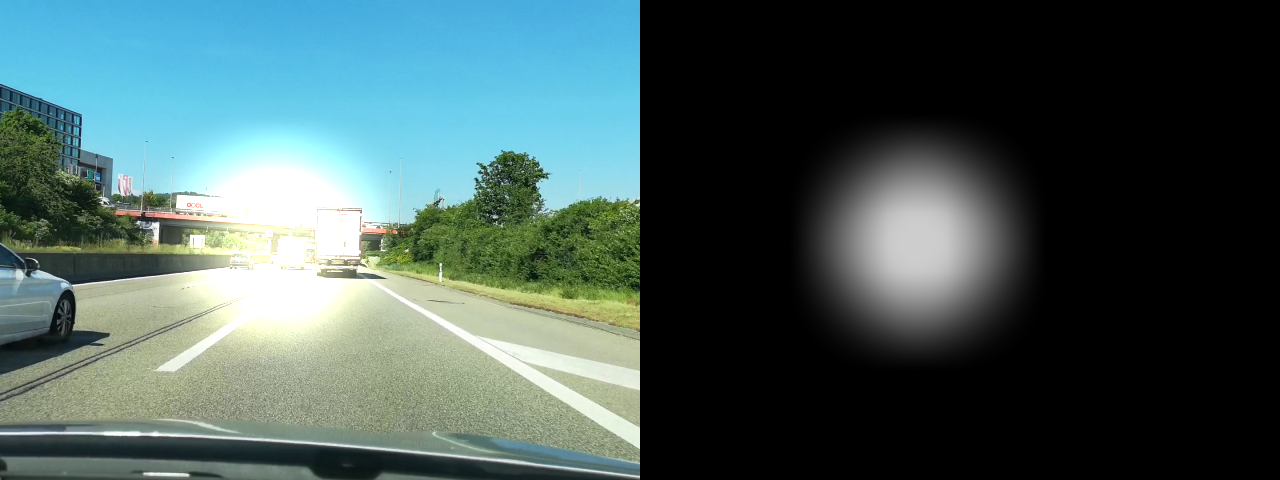

In [ ]:
x, y = dat[5]
print(y.shape)
x = (x.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
y = (y.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
# apply colorscale to gs image
y = cv2.cvtColor(y, cv2.COLOR_GRAY2BGR)
side_by_side = np.concatenate([x, y], axis=1)
showarray(side_by_side)

In [ ]:
np.random.seed(0)
dat = BGREMDataset(
    uzh_img_paths[:16],
    # ref_img_paths,
    # masker=transforms.DiffIntensityMasker(110),
    masker=transforms.RandomizedMasker(fix_by_idx=True),
    bgr_transform=T.Compose(
        [
            T.ToPILImage(),
            T.ToTensor(),
        ]
    ),
    event_transform=T.Compose(
        [
            # transforms.RandomizedSunAdder(1),
            # transforms.RandomizedBrightnessScaler(0.5, 1.5),
            # transforms.RandomizedContrastScaler(0.5, 1.5),
        ]
    ),
    masked_bgr_transform=T.Compose(
        [
            transforms.RandomizedMaskAwareGlareAdder(prob=1),
            transforms.RandomizedMaskAwareGrayscaleAdder(prob=0),
        ]
    ),
    separate_event_channel=False,
    blur_factor=10,
    yuv_interpolation=True,
)

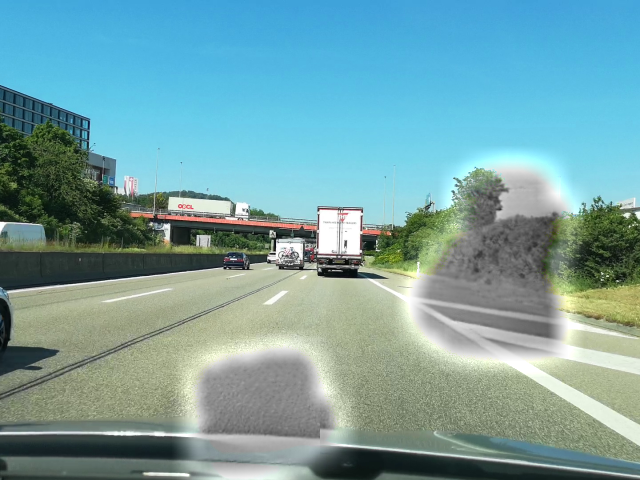

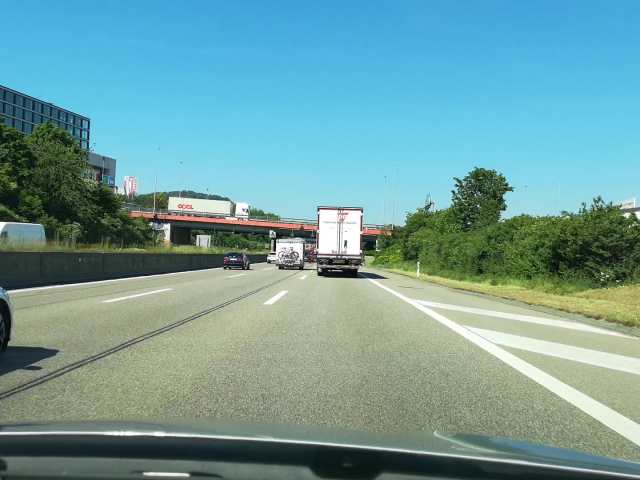

In [ ]:
np.random.seed(24)
x, y = dat[1]
x = (x.numpy().transpose(1, 2, 0) * 255.0).astype(np.uint8)
y = (y.numpy().transpose(1, 2, 0) * 255.0).astype(np.uint8)
showarray(x[:, :, :3])
showarray(y[:, :, :3])

In [ ]:
dl = torch.utils.data.DataLoader(dat, batch_size=8, shuffle=False)
batched_dat = list(dl)

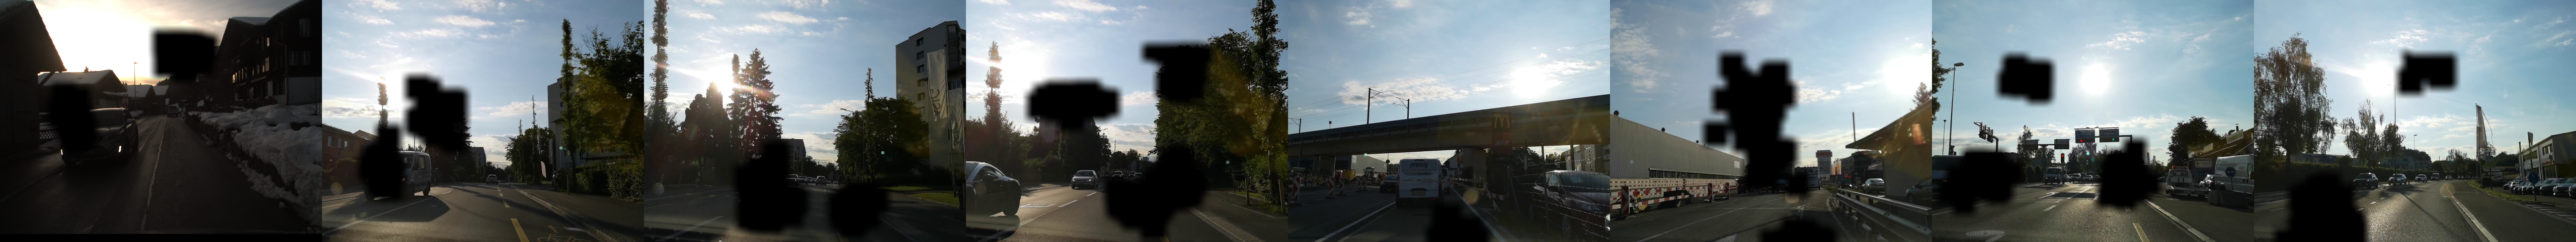

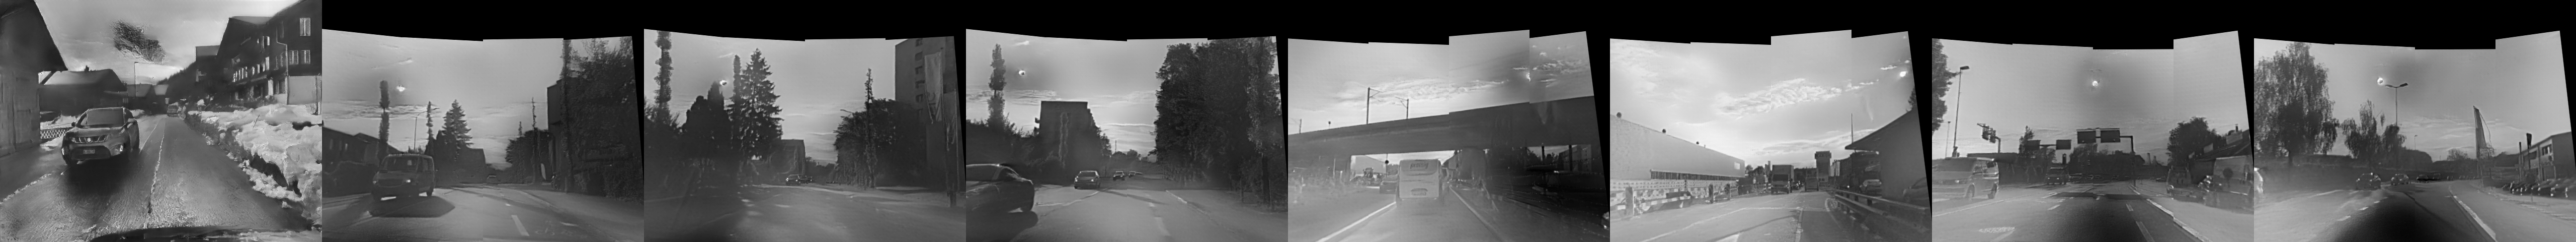

In [ ]:
x, _ = batched_dat[1]
x = (x.numpy().transpose(0, 2, 3, 1) * 255.0).astype(np.uint8)

x = np.concatenate(x, axis=1)
showarray(x[:, :, :3])
showarray(x[:, :, 3])
# showarray(x[:, :, 3][:, ::-1])

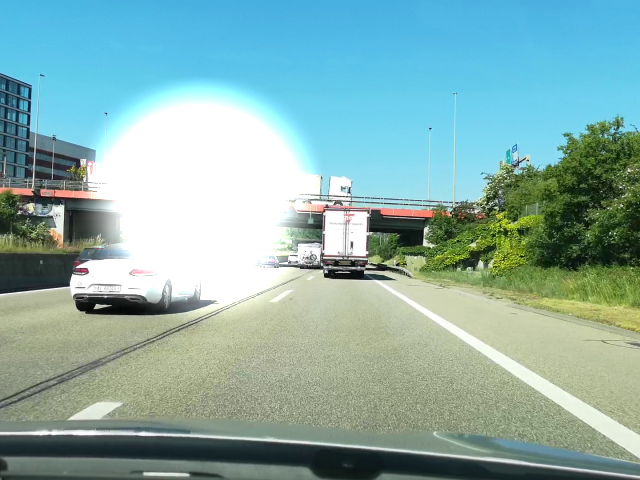

In [ ]:
# get random coords within mask
uzh_samp = np.load(uzh_img_paths[23])
uzh_samp_bgr = uzh_samp[:, :, :3]

mask = np.zeros_like(uzh_samp[:, :, :3])
mask = cv2.circle(mask, (200, 200), 100, (1, 1, 1), -1) * 255
mask = cv2.GaussianBlur(mask, (51, 51), 25)
uzh_samp_bgr_overlit = cv2.add(uzh_samp_bgr.copy(), mask)
showarray(uzh_samp_bgr_overlit)